In [ ]:
#Test mining final assignment

In [8]:


# importing the required libraries

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home3/zxww47/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home3/zxww47/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

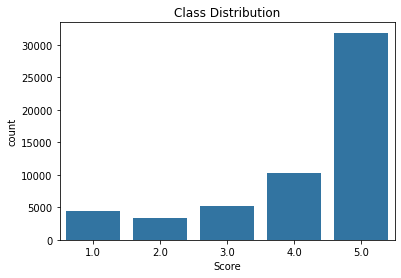

Score    4674
Text     4636
dtype: int64
Score    0
Text     0
dtype: int64


In [9]:
#loading the dataset
# Load the dataset
reviews_df = pd.read_csv('dataset.csv')

# Check class distribution
sns.countplot(x='Score', data=reviews_df)
plt.title('Class Distribution')
plt.show()

# check for mising values
print(reviews_df.isnull().sum())
reviews_df = reviews_df.dropna()
print(reviews_df.isnull().sum())

In [10]:
# drop duplicates if any
reviews_df = reviews_df.drop_duplicates()



In [11]:
# text preprocessing
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    # Lowercase
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    tokens = [word for word in tokens if word not in stop_words]
    
    return ' '.join(tokens)

reviews_df['clean_text'] = reviews_df['Text'].apply(preprocess_text)

In [12]:
# splitting the data into training and test data
X = reviews_df['clean_text']
y = reviews_df['Score']

# 70-30 data split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
#word embeddings


MAX_VOCABULARY_WORDS = 5000 # The maximum number of words to be used (most frequent)
MAX_SEQUENCE_LENGTH = 200 # Number of words in each text. Sequence length to pad the outputs to.
EMBEDDING_DIM = 10 # Size of the word embedding to be used

# Create a preprocessing layer which maps text features to integer sequences
vectorize_layer = TextVectorization(
    max_tokens=MAX_VOCABULARY_WORDS, # Maximum size of the vocabulary for this layer 
    output_mode='int', # Represent each word in the vocabulary with an integer 
    output_sequence_length=MAX_SEQUENCE_LENGTH) # Pad the sequence length to size MAX_SEQUENCE_LENGTH


vectorize_layer.adapt(X_train) # Computes a vocabulary of string terms from tokens in a dataset.
vocabulary = vectorize_layer.get_vocabulary() # Get the vocabulary

print("Vocabulary size: " + str(len(vocabulary)) + " words")

Vocabulary size: 5000 words


In [14]:
from sklearn.naive_bayes import MultinomialNB

X_train_vec = vectorize_layer(X_train)
X_test_vec = vectorize_layer(X_test)
# Building the Naive Bayes model by setting a pipeline where the input is first converted
# to word embedding and then a Multinomial Naive Bayes is used
nb_model = MultinomialNB()

nb_model.fit(X_train_vec, y_train)  # Train the model on the training data
pred_rating = nb_model.predict(X_test_vec) # Predict the scores of the test data

print("Predicted:",pred_rating.tolist()[0:10]) # Print the first 10 predictions
print("Actual:",y_test.tolist()[0:10]) # Print the first 10 actual values


Predicted: [5.0, 5.0, 3.0, 2.0, 4.0, 5.0, 5.0, 5.0, 5.0, 1.0]
Actual: [3.0, 5.0, 2.0, 1.0, 3.0, 4.0, 5.0, 5.0, 5.0, 2.0]


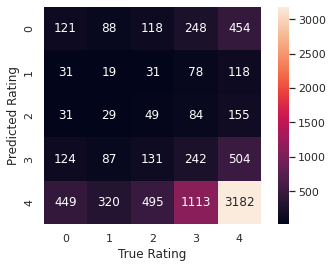

Accuracy:	0.435249
F1-score:	0.214673
Precision:	0.224364
Recall:		0.222534

Classification performance:
              precision    recall  f1-score   support

         1.0       0.12      0.16      0.14       756
         2.0       0.07      0.03      0.05       543
         3.0       0.14      0.06      0.08       824
         4.0       0.22      0.14      0.17      1765
         5.0       0.57      0.72      0.64      4413

    accuracy                           0.44      8301
   macro avg       0.22      0.22      0.21      8301
weighted avg       0.38      0.44      0.40      8301



In [15]:
# Computation and plotting of Naive Bayes’s classification performance

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score,precision_score,recall_score, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
sns.set() # use seaborn plotting style

# Plot the confusion matrix
mat = confusion_matrix(y_test, pred_rating)
sns.heatmap(mat.T, square = True, annot=True, fmt = "d")
plt.xlabel("True Rating")
plt.ylabel("Predicted Rating")
plt.show()

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(y_test, pred_rating)) 
print("F1-score:\t%f" % f1_score(y_test, pred_rating, average='macro')) 
print("Precision:\t%f" % precision_score(y_test, pred_rating, average='macro')) 
print("Recall:\t\t%f" % recall_score(y_test, pred_rating, average='macro'))
print("\nClassification performance:\n%s" % classification_report(y_test, pred_rating))

In [16]:
import pickle

# Save to file in the current working directory
pkl_filename = 'naive_bayes_model.pkl'
with open(pkl_filename, 'wb') as file: # Open file as binary file for writing (wb)
    pickle.dump(nb_model, file)


K=1, Accuracy: 0.3671846765449946
K=3, Accuracy: 0.3688712203348994
K=5, Accuracy: 0.4201903385134321
K=7, Accuracy: 0.45151186604023613
K=9, Accuracy: 0.473075533068305


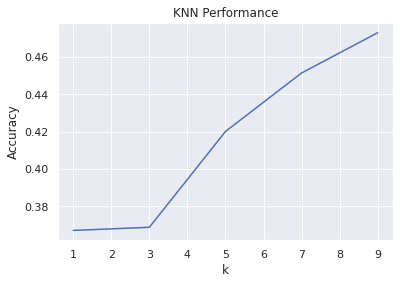

In [18]:
from sklearn.neighbors import KNeighborsClassifier

k_values = [1, 3, 5, 7, 9]
scores = []

for k in k_values:
    knn_model = KNeighborsClassifier(n_neighbors=k)
    knn_model.fit(X_train_vec, y_train)
    y_pred_knn = knn_model.predict(X_test_vec)
    acc = accuracy_score(y_test, y_pred_knn)
    scores.append(acc)
    print(f"K={k}, Accuracy: {acc}")

# Plot k vs. accuracy
plt.plot(k_values, scores)
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.title('KNN Performance')
plt.show()

# Choose best k and save model
best_k = k_values[np.argmax(scores)]
best_knn_model = KNeighborsClassifier(n_neighbors=best_k)
best_knn_model.fit(X_train_vec, y_train)

# Save to file in the current working directory
pkl_filename = 'knn_model.pkl'
with open(pkl_filename, 'wb') as file: # Open file as binary file for writing (wb)
    pickle.dump(knn_model, file)

In [19]:
knn_pred = knn_model.predict(X_test_vec)

# Computing and printing classification performance metrics
print("Accuracy:\t%f" % accuracy_score(y_test, knn_pred)) 
print("F1-score:\t%f" % f1_score(y_test, knn_pred, average='macro')) 
print("Precision:\t%f" % precision_score(y_test, knn_pred, average='macro')) 
print("Recall:\t\t%f" % recall_score(y_test, knn_pred, average='macro'))
print("\nClassification performance:\n%s" % classification_report(y_test, knn_pred))

Accuracy:	0.473076
F1-score:	0.178548
Precision:	0.201980
Recall:		0.201156

Classification performance:
              precision    recall  f1-score   support

         1.0       0.14      0.03      0.04       756
         2.0       0.05      0.01      0.01       543
         3.0       0.08      0.02      0.03       824
         4.0       0.21      0.12      0.15      1765
         5.0       0.54      0.83      0.65      4413

    accuracy                           0.47      8301
   macro avg       0.20      0.20      0.18      8301
weighted avg       0.35      0.47      0.39      8301



In [20]:
# CNN model

import tensorflow as tf
from tensorflow.keras import layers, models


# NOTE: the classes in the classificatoin reports show from 0 to 4 and in the file the scores go from 1 to 5,
# this is because the labels in the dataset (y_train) contain values from 1 to 5.
# however, TensorFlow's sparse_categorical_crossentropy loss expects the labels to be zero-indexed (starting from 0 instead of 1).
# In this case, the labels should range from 0 to 4, not 1 to 5.
y_train_adjusted = y_train - 1
y_test_adjusted = y_test - 1


# Convert text to padded sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=200)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=200)

# Build CNN model
cnn_model = models.Sequential([
    layers.Embedding(input_dim=5000, output_dim=128, input_length=200),
    layers.Conv1D(64, 5, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Conv1D(128, 5, activation='relu'),
    layers.MaxPooling1D(2),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(5, activation='softmax')
])

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
cnn_model.summary()

# Train and save model
cnn_model.fit(X_train_seq, y_train_adjusted, epochs=5, batch_size=64, validation_split=0.1)
cnn_model.save('cnn_model.h5')

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 200, 128)          640000    
                                                                 
 conv1d (Conv1D)             (None, 196, 64)           41024     
                                                                 
 max_pooling1d (MaxPooling1  (None, 98, 64)            0         
 D)                                                              
                                                                 
 conv1d_1 (Conv1D)           (None, 94, 128)           41088     
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 47, 128)           0         
 g1D)                                                            
                                                                 
 flatten (Flatten)           (None, 6016)              0

/apps/jupyterhub/COMP42415/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:

cnn_pred = cnn_model.predict(X_test_seq)
cnn_pred_labels = np.argmax(cnn_pred, axis=1)

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(y_test_adjusted, cnn_pred_labels))
print("F1-score:\t%f" % f1_score(y_test_adjusted, cnn_pred_labels, average='macro'))
print("Precision:\t%f" % precision_score(y_test_adjusted, cnn_pred_labels, average='macro'))
print("Recall:\t%f" % recall_score(y_test_adjusted, cnn_pred_labels, average='macro'))
print("\nClassification performance:\n%s" % classification_report(y_test_adjusted, cnn_pred_labels))


260/260 [==============================] - 4s 15ms/step
Accuracy:	0.601614
F1-score:	0.439796
Precision:	0.451585
Recall:	0.436493

Classification performance:
              precision    recall  f1-score   support

         0.0       0.54      0.55      0.55       756
         1.0       0.26      0.13      0.18       543
         2.0       0.30      0.30      0.30       824
         3.0       0.38      0.39      0.39      1765
         4.0       0.77      0.81      0.79      4413

    accuracy                           0.60      8301
   macro avg       0.45      0.44      0.44      8301
weighted avg       0.59      0.60      0.59      8301



In [22]:
#building the LSTM with 5 layers
from tensorflow.keras.layers import LSTM

# Build LSTM model
lstm_model = models.Sequential([
    layers.Embedding(input_dim=5000, output_dim=128, input_length=200),
    layers.LSTM(128, return_sequences=True),
    layers.LSTM(64),
    layers.Dense(64, activation='relu'), # activation function for non-linearity
    layers.Dense(5, activation='softmax') # activation function (softmax) for classification
])

lstm_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
lstm_model.summary()

# Train and save model
lstm_model.fit(X_train_seq, y_train_adjusted, epochs=5, batch_size=64, validation_split=0.1)
lstm_model.save('lstm_model.h5')


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 200, 128)          640000    
                                                                 
 lstm (LSTM)                 (None, 200, 128)          131584    
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dense_3 (Dense)             (None, 5)                 325       
                                                                 
Total params: 825477 (3.15 MB)
Trainable params: 825477 (3.15 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
467/467 

/apps/jupyterhub/COMP42415/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [23]:
lstm_pred = lstm_model.predict(X_test_seq)
lstm_pred_labels = np.argmax(lstm_pred, axis=1)

# Compute and print classification performance metrics
print("Accuracy:\t%f" % accuracy_score(y_test_adjusted, lstm_pred_labels))
print("F1-score:\t%f" % f1_score(y_test_adjusted, lstm_pred_labels, average='macro'))
print("Precision:\t%f" % precision_score(y_test_adjusted, lstm_pred_labels, average='macro'))
print("Recall:\t%f" % recall_score(y_test_adjusted, lstm_pred_labels, average='macro'))
print("\nClassification performance:\n%s" % classification_report(y_test_adjusted, lstm_pred_labels))

260/260 [==============================] - 30s 114ms/step
Accuracy:	0.629683
F1-score:	0.452175
Precision:	0.487318
Recall:	0.435672

Classification performance:
              precision    recall  f1-score   support

         0.0       0.59      0.49      0.53       756
         1.0       0.33      0.24      0.27       543
         2.0       0.35      0.26      0.30       824
         3.0       0.44      0.29      0.35      1765
         4.0       0.72      0.91      0.81      4413

    accuracy                           0.63      8301
   macro avg       0.49      0.44      0.45      8301
weighted avg       0.59      0.63      0.60      8301



In [24]:
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)
    
# Model evaluation
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    y_pred_classes = np.argmax(y_pred, axis=1)
    print(confusion_matrix(y_test, y_pred_classes))
    print(classification_report(y_test, y_pred_classes))
    print("Accuracy:", accuracy_score(y_test, y_pred_classes))


In [34]:
import numpy as np
import pickle
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import load_model

# Preprocess text function
def preprocess_text(text):
    # Lowercase the text
    text = text.lower()
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove special characters and numbers
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    
    return text

def predict_product_rating(text, model_filename):
    # Preprocess the text
    text_clean = preprocess_text(text)

    # Tokenize using simple word splitting
    tokens = text_clean.split()

    # Simple mapping for tokens
    word_to_index = {word: i+1 for i, word in enumerate(set(tokens))}
    text_seq = [word_to_index.get(word, 0) for word in tokens]
    
    # Pad sequence to max length (200)
    text_pad = pad_sequences([text_seq], maxlen=200)

    # Load and predict using the appropriate model
    if model_filename.endswith('.pkl'):
        with open(model_filename, 'rb') as f:
            model = pickle.load(f)
        prediction = model.predict(text_pad)
        return prediction[0]

    elif model_filename.endswith('.h5'):
        model = load_model(model_filename)
        prediction = model.predict(text_pad, verbose=0)
        return np.argmax(prediction[0])

    else:
        raise ValueError("Unsupported model file format. Please use .pkl or .h5.")

# Example predictions
print(f"{'Review':<50} {'Actual':<10} {'Naive Bayes':<10} {'k-NN':<10} {'CNN':<10} {'LSTM':<10}")
print("=" * 110)


tf.config.run_functions_eagerly(False) # to remove the warnings from the table that will be printed below.
tf.function(reduce_retracing=True)

for review, actual_rating in zip(reviews_df['Text'], reviews_df['Score']):
    nb_prediction = predict_product_rating(review, 'naive_bayes_model.pkl')
    knn_prediction = predict_product_rating(review, 'knn_model.pkl')
    cnn_prediction = predict_product_rating(review, 'cnn_model.h5')
    lstm_prediction = predict_product_rating(review, 'lstm_model.h5')

    print(f"{review[:45]:<50} {actual_rating:<10} {nb_prediction:<10} {knn_prediction:<10} {cnn_prediction:<12} {lstm_prediction:<12}")



Review                                             Actual     Naive Bayes k-NN       CNN        LSTM      
It is a nice made necklace, and the butterfly      4.0        5.0        5.0        4            4           
I bought this necklace on a whim; I love butt      4.0        5.0        5.0        4            4           
Bought via gold box ,it is much better than I      5.0        5.0        5.0        4            4           
Love this butterfly pendant. Right size, high      5.0        5.0        5.0        4            4           
I bought this as a graduation gift for my dau      5.0        1.0        5.0        4            4           
The locket has a very nice appearance and the      3.0        5.0        5.0        4            4           
I have generally had very good experience ord      1.0        5.0        5.0        4            4           
A beautiful, delicate little bracelet. I feel      5.0        5.0        5.0        4            4           
I think it's 

KeyboardInterrupt: 

## Predicting Product Rating Scores Based on Product Reviews




**Dataset**

The dataset used in this assignment contains two columns: `Score` and `Text`. The Score represents the product rating, which ranges from 1 to 5, while the Text column contains the product review written by customers. 

 Class Imbalance
 
A significant class imbalance was evident in the dataset, as follows:
- Score 5.0: Over 30,000 reviews
- Score 4.0: Over 10,000 reviews
- Score 3.0: About 5,000 reviews
- Score 2.0: About 3,000 reviews
- Score 1.0: About 4,000 reviews

 

This class imbalance could bias models toward the dominant class (Score 5.0). After loading the dataset, it was observed that the dataset had 54,985 reviews, out of which 54,947 had valid scores. There were missing values and which were subsequently removed, ensuring clean data for analysis.



Suitability and Problems
The dataset's size and range of scores made it suitable for supervised machine learning. However, class imbalance and potential subjectivity in ratings were challenges. Additionally, the dataset contained unstructured text data, requiring preprocessing to extract meaningful features.


**Data Preparation**

 Preprocessing Steps

A comprehensive text preprocessing pipeline was implemented using the following steps:
1. Lowercasing: All text was converted to lowercase to maintain uniformity.
2. URL Removal: URLs were removed using regular expressions to clean unnecessary information.
3. Special Character Removal: Punctuation, numbers, and special characters were removed to retain only alphabets.
4. Tokenization: Text was split into individual words using the NLTK tokenizer.
5. Stopword Removal: Common words like "the," "is," and "and" were removed using the NLTK stopword list.
6. Rejoining Tokens: Processed tokens were joined back into clean sentences.

These preprocessing steps ensured the text data was clean and suitable for vectorization and further modeling.

*Data Splitting*
 
 
The dataset was divided into training and testing sets using a 80-20 split to ensure sufficient data for both model training and evaluation. The following variables were used:
- X_train, X_test: Cleaned text data
- y_train, y_test: Corresponding product scores

*Text Representation*
 
 
A TextVectorization layer was used to convert text into numerical data for machine learning models. Key parameters included:
- MAX_VOCABULARY_WORDS = 5000: Limited to the most common 5,000 words.
- MAX_SEQUENCE_LENGTH = 200: Each review was truncated or padded to 200 words.
- EMBEDDING_DIM = 10: Word embeddings were generated with a size of 10 dimensions.

This representation allowed models like Naïve Bayes and k-Nearest Neighbors (k-NN) to handle text input efficiently.


**Machine Learning Models**

 i. Naïve Bayes
The Multinomial Naïve Bayes (NB) classifier was used, as it is suitable for text classification tasks. It applies Bayes' theorem and assumes conditional independence between words. Using the vectorized data, the model was trained and evaluated. 

 ii. k-Nearest Neighbors (k-NN)
The k-NN classifier was used to predict scores based on the closest training samples. Various values of k (1, 3, 5, 7, 9) were tested to find the optimal number of neighbors. Accuracy was observed to improve as k increased, with the best performance at k = 9.

 iii. Convolutional Neural Network (CNN)
The CNN model applied multiple convolutional layers with ReLU activation to extract spatial patterns from the text data. Key layers included:
- Embedding Layer: Converted words to dense vectors of size 128.
- Conv1D and MaxPooling: Detected local patterns in the data.
- Flatten and Dense Layers: Performed classification using a softmax activation function.

The CNN demonstrated significant improvements over traditional models.

 iv. Long Short-Term Memory (LSTM)
The LSTM model was designed to capture sequential dependencies using memory cells. The architecture included:
- Embedding Layer: Similar to the CNN.
- Two LSTM Layers: Captured long-term dependencies in the text data.
- Dense Layers: Classified the outputs using softmax activation.

LSTMs are particularly effective for tasks like sentiment analysis where context matters.


**Experimental Results**

The models were evaluated using accuracy, F1-score, precision, and recall. The results are summarized below:

| Model               | Accuracy | F1-Score | Precision | Recall |
|---------------------|----------|----------|-----------|--------|
| Naïve Bayes         | 0.435    | 0.215    | 0.224     | 0.222  |
| k-Nearest Neighbors | 0.473    | 0.178    | 0.202     | 0.201  |
| CNN                 | 0.601    | 0.440    | 0.451     | 0.436  |
| LSTM                | 0.630    | 0.452    | 0.487     | 0.436  |

 Observations:
- LSTM outperformed other models, achieving the highest accuracy of 63.0% and a F1-score of 0.452.
- CNN followed closely with an accuracy of 60.1%. Its ability to capture local patterns in text contributed to its performance.
- Naïve Bayes and k-NN struggled, with F1-scores below 0.22. These traditional models were unable to capture complex linguistic features.

---

**Discussion**

 Model Performance
- LSTMs excelled due to their sequential memory capabilities, making them well-suited for text classification. 
- CNNs effectively extracted local patterns but struggled with long-term dependencies compared to LSTMs.
- Naïve Bayes performed poorly due to its oversimplified assumptions of word independence.
- k-NN is inefficient with large datasets, leading to poor accuracy.

*Class Imbalance Impact*

The significant class imbalance likely caused models to predict dominant classes (Score 5.0) more frequently. This was evident in the high recall for Score 5.0 but low recall for lower scores. Techniques like class weighting could mitigate this effect.

*Limitations*
- The models were only trained for 5 epochs. Additional training could improve performance.

*Further Improvements*
- Fine-tuning hyperparameters, increasing epochs, and using larger embedding dimensions may yield better results.
- Implementing ensemble models that combine CNN and LSTM could leverage both models' strengths.

**Conclusion**

The LSTM model proved to be the most effective for predicting product ratings from reviews, demonstrating superior accuracy and F1-scores and CNN was a close second.
